In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from pyDOE import lhs

from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.empty_cache()
torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device = ', device)

device =  cpu


In [3]:
class Plain(nn.Module):
    
    def __init__(self, in_dim , h_dim , out_dim):
        super().__init__()
        self.ln1 = nn.Linear( in_dim , h_dim )
        self.act1 =nn.Sigmoid()
        self.ln2 = nn.Linear( h_dim , out_dim , bias=False )
        
    def forward(self, x):
        out = self.ln1(x)
        out = self.act1(out)
        out = self.ln2(out)
        return out
    
def count_parameters(model, requires_grad = True):
    """Count trainable parameters for a nn.Module."""
    if requires_grad:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

In [4]:
def loss(model, X_inner, Rf_inner, X_bd, U_bd, X_ij, Normal_ij, Uj_ij, Unj_ij):
    
# loss_bd: boundary condition
    bd_pred = model(X_bd)
    loss_bd = torch.mean((bd_pred - U_bd) ** 2)

# loss_res: system residual
    inner_pred = model(X_inner)
    dudX = torch.autograd.grad(
        inner_pred, X_inner, 
        grad_outputs=torch.ones_like(inner_pred), 
        retain_graph=True,
        create_graph=True
        )[0] # u_x u_y
    dudX_xX = torch.autograd.grad(
        dudX[:,0], X_inner, 
        grad_outputs=torch.ones_like(dudX[:,0]), 
        retain_graph=True,
        create_graph=True
        )[0] # u_xx u_xy
    dudX_yX = torch.autograd.grad(
        dudX[:,1], X_inner, 
        grad_outputs=torch.ones_like(dudX[:,1]), 
        retain_graph=True,
        create_graph=True
        )[0] # u_yx u_yy
    laplace = (dudX_xX[:,0] + dudX_yX[:,1]) #u_xx + u_yy
    loss_res = torch.mean((laplace - Rf_inner.squeeze(1)) ** 2)

# loss_jump: jump condition
    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)
    ij_inner = torch.cat([X_ij[:,0:2], -1.0+0.0*X_ij[:,0:1]], dim=1)

    u_ij_outer = model(ij_outer)

    ux_ij_outer = torch.autograd.grad(
        u_ij_outer, ij_outer, 
        grad_outputs=torch.ones_like(u_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]
    
    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    
    Normal_outer = normal_x*ux_ij_outer[:,0:1] + normal_y*ux_ij_outer[:,1:2]

    u_ij_inner = model(ij_inner)

    ux_ij_inner = torch.autograd.grad(
        u_ij_inner, ij_inner, 
        grad_outputs=torch.ones_like(u_ij_inner),
        retain_graph=True,
        create_graph=True
    )[0]

    Normal_inner = normal_x*ux_ij_inner[:,0:1] + normal_y*ux_ij_inner[:,1:2]

    jump_pred = u_ij_outer - u_ij_inner
    loss_jump = torch.mean((jump_pred - Uj_ij)**2)

    normal_jump_pred = 1.0e-3*Normal_outer - Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Unj_ij)**2)

    loss = loss_bd + loss_res + loss_jump + loss_normal_jump

    return loss

In [5]:
# exact_u = exact solution
def exact_u(x, y, z):
    u1 = np.sin(x)*np.sin(y)
    un1 = np.exp(x+y)
    eu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return eu

# rf_u = right hand side function
def rf_u(x, y, z):
    f1 = -2.0*np.sin(x)*np.sin(y)
    fn1 = 2.0*np.exp(x+y)
    rf = f1*(1.0+z)/2.0 + fn1*(1.0-z)/2.0
    return rf

# normal_u = \nabla u \dot n, normal derivative of u, only defined on the interface
def normal_u(x, y, z):
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    u1x = np.cos(x)*np.sin(y)
    u1y = np.sin(x)*np.cos(y)
    u1 = normal_x*u1x + normal_y*u1y
    un1x = np.exp(x+y)
    un1y = np.exp(x+y)
    un1 = normal_x*un1x + normal_y*un1y
    nu = u1*(1.0+z)/2.0 + un1*(1.0-z)/2.0
    return nu

# normal_vector = normal vector, only defined on the interface
def normal_vector(x, y):
    dist = np.sqrt((25.0*x)**2 + (4.0*y)**2)
    normal_x = 25.0*x/dist
    normal_y = 4.0*y/dist
    normal = np.hstack((normal_x, normal_y))
    return normal

def sign_x(x, y):
    z = 0.0*x + 1.0
    for i in range(len(z)):
        dist = np.sqrt((x[i]/0.2)**2+(y[i]/0.5)**2)
        if dist < 1.0:
            z[i] = -1.0
    return z

In [6]:
def chebyshev_first_kind(dim,n):
  a_new=(1.0/n)-1.0
  X=[]
  x=[]
  X=(np.mgrid[[slice(None,n),]*dim])
  XX=np.cos(np.pi*(X+0.5)/n)
  for i in range(len(X)):
    x.append(np.array(XX[i].tolist()).reshape(n**dim,1))
  return np.hstack(np.array(x))

In [7]:
# number of grid points
N_inner = 8

# Training points

## X_inner: points inside the domain, totally (N_inner)**2 points
X_inner = chebyshev_first_kind(2, N_inner)
x = X_inner[:,0:1]
y = X_inner[:,1:2]
z = sign_x(x, y)
X_inner = np.hstack((X_inner, z))
Rf_inner = rf_u(x, y, z)

## X_bd: points on the boundary, totally 4*N_inner points
cheby_point = chebyshev_first_kind(1, N_inner)
dumy_one = np.ones((N_inner,1))
xx1 = np.hstack((cheby_point, -1.0*dumy_one, dumy_one))
xx2 = np.hstack((-1.0*dumy_one, cheby_point, dumy_one))
xx3 = np.hstack((dumy_one, cheby_point, dumy_one))
xx4 = np.hstack((cheby_point, dumy_one, dumy_one))
X_bd = np.vstack([xx1, xx2, xx3, xx4])

## U_bd: function values on the boundary, totally 4*N_inner points
x = X_bd[:,0:1]
y = X_bd[:,1:2]
z = 0.0*x + 1.0
U_bd = exact_u(x, y, z)

## X_ij: points on the interior interface, totally 4*N_inner points
theta = 2.0*np.pi*lhs(1, 4*N_inner)
x_ij = 0.2*np.cos(theta)
y_ij = 0.5*np.sin(theta)
X_ij = np.hstack([x_ij, y_ij])

## normal vector
Normal_ij = normal_vector(x_ij, y_ij)

## Uj_ij: function jump on the interior interface, totally 4*N_inner points
Uj_ij = exact_u(x_ij, y_ij, 0.0*x_ij+1.0) - exact_u(x_ij, y_ij, 0.0*x_ij-1.0)

# beta_plus
beta_plus = 1.0e-3
## Unj_ij: normal jump on the interior interface, totally 4*N_inner points
Unj_ij = beta_plus*normal_u(x_ij, y_ij, 0.0*x_ij+1.0) - normal_u(x_ij, y_ij, 0.0*x_ij-1.0)

print('Size of inner points: ', X_inner.shape)
print('Size of boundary points: ', X_bd.shape)
print('Size of interface points: ', X_ij.shape)

Size of inner points:  (64, 3)
Size of boundary points:  (32, 3)
Size of interface points:  (32, 2)


In [8]:
X_bd_torch = torch.from_numpy(X_bd).requires_grad_(True).double().to(device)
U_bd_torch = torch.from_numpy(U_bd).double().to(device)
X_inner_torch = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
Rf_inner_torch = torch.from_numpy(Rf_inner).double().to(device)
X_ij_torch = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij_torch = torch.from_numpy(Normal_ij).double().to(device)
Uj_ij_torch = torch.from_numpy(Uj_ij).double().to(device)
Unj_ij_torch = torch.from_numpy(Unj_ij).double().to(device)

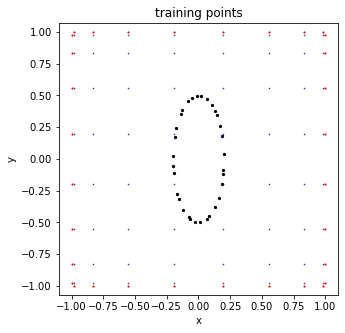

In [9]:
plt.figure(figsize = (5,5))

plt.scatter(X_inner[:,0], X_inner[:,1],
            c = "b", s = 1, marker = ".")
plt.scatter(X_bd[:,0], X_bd[:,1],
            c = "r", s = 5, marker = ".")
plt.scatter(X_ij[:,0], X_ij[:,1],
            c = "k", s = 5, marker = "o")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('training points')

plt.show()

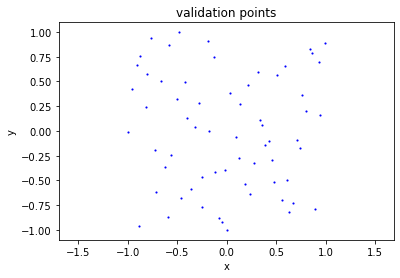

In [10]:
# Validation points

## X_inner: points inside the domain, totally (N_inner)**2 points
X_inner = 2.0*lhs(2, (N_inner)**2) - 1.0
x = X_inner[:,0:1]
y = X_inner[:,1:2]
z = sign_x(x, y)
X_valid_inner = np.hstack((X_inner, z))
Rf_valid_inner = rf_u(x, y, z)

X_valid_inner_torch = torch.from_numpy(X_valid_inner).requires_grad_(True).double().to(device)
Rf_valid_inner_torch = torch.from_numpy(Rf_valid_inner).double().to(device)

plt.scatter(X_valid_inner[:,0], X_valid_inner[:,1], c = "b", s = 5, marker = ".") 
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('validation points')

plt.show()

In [11]:
# one-hidden-layer model
num_neuron = 20

model = Plain(3, num_neuron, 1).to(device)
print(model)

print(f"Number of paramters: {count_parameters(model)}")

Plain(
  (ln1): Linear(in_features=3, out_features=20, bias=True)
  (act1): Sigmoid()
  (ln2): Linear(in_features=20, out_features=1, bias=False)
)
Number of paramters: 100


In [12]:
Adam_iter = 50000 # stop when iter > Adam_iter
update_lr_1 = 15000  # change adam lr from 0.01 to 0.001 at update_lr_1 iteration
update_lr_2 = 30000  # change adam lr from 0.001 to 0.0001 at update_lr_2 iteration

optimizerAdam = torch.optim.Adam(
    model.parameters(), 
    lr=0.01
)

In [13]:
itera = 0

savedloss = []
savedloss_valid = []

In [14]:
%%time

model.train()
for step in range(Adam_iter+1):
    if step == update_lr_1:
        print('change learning rate to 0.001')
        for g in optimizerAdam.param_groups:
            g['lr'] = 0.001
    if step == update_lr_2:
        print('change learning rate to 0.0001')
        for g in optimizerAdam.param_groups:
            g['lr'] = 0.0001
              
    # Backward and optimize
    optimizerAdam.zero_grad()

    lossAdam = loss(model, X_inner_torch, Rf_inner_torch, X_bd_torch, U_bd_torch, X_ij_torch, Normal_ij_torch, Uj_ij_torch, Unj_ij_torch)
    lossAdam_valid = loss(model, X_valid_inner_torch, Rf_valid_inner_torch, X_bd_torch, U_bd_torch, X_ij_torch, Normal_ij_torch, Uj_ij_torch, Unj_ij_torch)
    
    if step % 5000 == 0:
        print('Iter %d, LossAdam: %.5e' % (itera, lossAdam.item()))

    savedloss.append(lossAdam.item())
    savedloss_valid.append(lossAdam_valid.item())
    lossAdam.backward(retain_graph = True)
        
    if step == Adam_iter:
        break

    optimizerAdam.step()
    itera += 1

Iter 0, LossAdam: 3.90542e+00
Iter 5000, LossAdam: 7.40043e-05
Iter 10000, LossAdam: 3.22422e-05
change learning rate to 0.001
Iter 15000, LossAdam: 1.55151e-05
Iter 20000, LossAdam: 1.36604e-05
Iter 25000, LossAdam: 1.08816e-05
change learning rate to 0.0001
Iter 30000, LossAdam: 1.00162e-05
Iter 35000, LossAdam: 8.83138e-06
Iter 40000, LossAdam: 8.05489e-06
Iter 45000, LossAdam: 7.54158e-06
Iter 50000, LossAdam: 7.10733e-06
CPU times: user 2min 14s, sys: 333 ms, total: 2min 14s
Wall time: 2min 14s


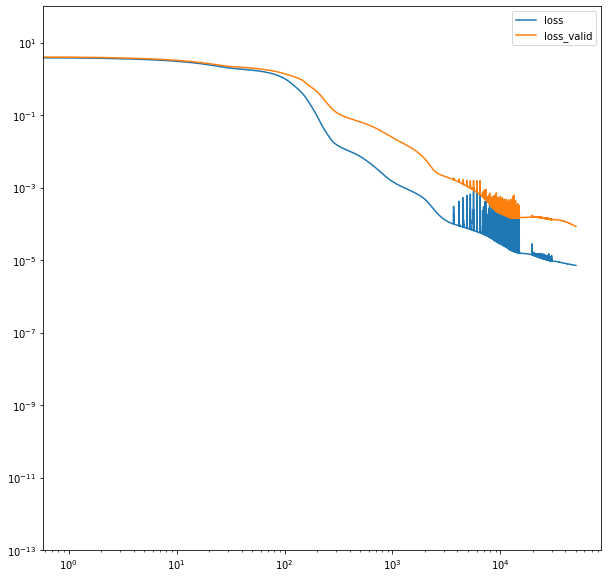

In [15]:
start = 0
end = itera
idx = list(range(start, end, 1))

fig = plt.figure(figsize= (10, 10))
plt.ylim(10**(-13), 10**(2))
plt.yscale("log")
plt.xscale("log")
plt.plot(idx, savedloss[start:end], label = "loss")
plt.plot(idx, savedloss_valid[start:end], label = "loss_valid")
plt.legend()
plt.show()

In [16]:
# number of test points
N_test = 12800

# Error on the interior points
X_inn = 2.0*lhs(2, N_test) - 1.0
xx = X_inn[:,0:1]
yy = X_inn[:,1:2]
zz = sign_x(xx, yy)
u_test = exact_u(xx, yy, zz)
X_inn = np.hstack((X_inn, zz))
X_inn_torch = torch.tensor(X_inn).double().to(device)
u_pred = model(X_inn_torch).detach().cpu().numpy()

error = np.absolute(u_pred - u_test)

error_u_inf_r = np.linalg.norm(error, np.inf)/np.linalg.norm(u_test, np.inf)
print('Error u (relative inf-norm): %e' % (error_u_inf_r))
error_u_2r = np.linalg.norm(error,2)/np.linalg.norm(u_test,2)
print('Error u (relative 2-norm): %e' % (error_u_2r))
error_u_inf = np.linalg.norm(error, np.inf)
print('Error u (absolute inf-norm): %e' % (error_u_inf))
error_u_2 = np.linalg.norm(error,2)/np.sqrt(N_test)
print('Error u (absolute 2-norm): %e' % (error_u_2))

Error u (relative inf-norm): 7.762680e-04
Error u (relative 2-norm): 1.065196e-03
Error u (absolute inf-norm): 1.319852e-03
Error u (absolute 2-norm): 4.317734e-04


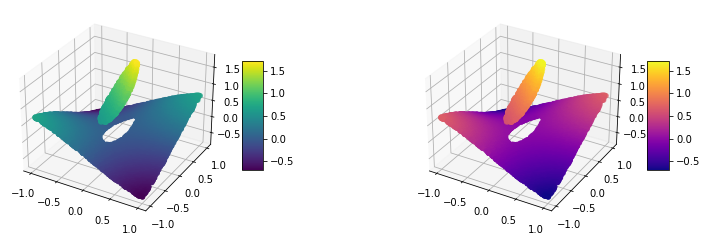

In [17]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(xx, yy, u_pred, c=u_pred)
fig.colorbar(surf, shrink=0.5, aspect=5)

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.scatter(xx, yy, u_test, c=u_test, cmap='plasma')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

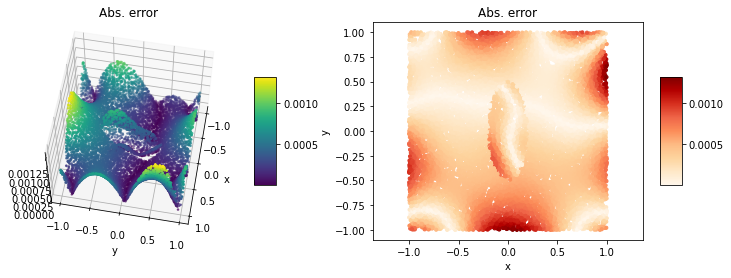

In [18]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.3))

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.scatter(xx, yy, error, c=error, cmap='viridis', marker = ".", s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=60, azim=10)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2)
surf = ax.scatter(xx, yy, c=error, cmap='OrRd', s = 10)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Abs. error')
ax.axis('equal')
plt.show()